<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Statistical Modeling and Model Validation

---

## Objective
The goal of this lab is to guide you through the modeling workflow to produce the best model you can. Here you will follow all best practices when exploring, cleaning, slicing, etc. your data and validating your model. 

### Imports

In [181]:
# Import everything you need here.
# You may want to return to this cell to import more things later in the lab.

# Try not to copy and paste from our class slides
# Muscle memory is important!

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer     # Useful for simple imputing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics  import r2_score

from sklearn.dummy import DummyRegressor     # Regressor that predict target using mean

### Read Data
The `citibike` dataset consists of CitiBike ridership data for over 224,000 rides in February 2014.

In [182]:
# The dataset is contained in the `data` folder
df = pd.read_csv('data/citibike_feb2014.csv')

### Explore the data
Use this space to familiarize yourself with the data.

Convince yourself there are no issues with the data. If you find any issues, clean them here.

In [183]:
df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,382,2014-02-01 00:00:00,2014-02-01 00:06:22,294,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,21101,Subscriber,1991,1


In [184]:
# Check missing data
# df.isnull().sum()
# no NaNs

In [185]:
# Check type of each column
df.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                  object
gender                       int64
dtype: object

In [186]:
# found that starttime and stoptime are string -> format to datetime
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [187]:
df[df['birth year'].apply(lambda x: not str(x).startswith("19"))]['birth year'].value_counts()

birth year
\N      6717
1899       9
Name: count, dtype: int64

In [188]:
df['birth year'].value_counts().sort_index()

birth year
1899       9
1900      68
1901      11
1907       5
1910       4
        ... 
1994    1215
1995     827
1996     334
1997     251
\N      6717
Name: count, Length: 78, dtype: int64

In [189]:
# The birth year has \N as NaNs
# We will impute with median
# For using simple imputer, we first transform '\N' with NaN, then change to median

df['birth year'] = df['birth year'].replace('\\N', np.nan)                  # transform '\\N' to NaN

imputer = SimpleImputer(strategy = 'median')                                # instantiate imputer

df['birth year'] = imputer.fit_transform(df[['birth year']]).astype(int)    # impute with median

In [190]:
# There are outliers in tripduration
# Thus, remove all rows that tripduration exceeding Q3 + 1.5 IQR

# df['tripduration'].describe()
# count    224736.000000
# mean        874.519810
# std        5486.092219
# min          60.000000
# 25%         360.000000
# 50%         544.000000
# 75%         845.000000
# max      766108.000000

ub = df['tripduration'].quantile(.75) + 1.5 * (df['tripduration'].quantile(.75) - df['tripduration'].quantile(.25))

df = df[df['tripduration'] <= ub]

# After
# count    210163.000000
# mean        590.284308
# std         321.182694
# min          60.000000
# 25%         349.000000
# 50%         518.000000
# 75%         766.000000
# max        1572.000000

-----

### What numeric columns shouldn't be treated as numeric?

**Answer:** Although `start station id` and `end station id` are numeric; they are nominal and shouldn't be treated as numeric.

### Dummify the `start station id` variable

In [191]:
df = pd.get_dummies(df, columns = ['start station id'], drop_first = True)

In [192]:
df.head(1)

,tripduration,starttime,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,...,start station id_2006,start station id_2008,start station id_2009,start station id_2010,start station id_2012,start station id_2017,start station id_2021,start station id_2022,start station id_2023,start station id_3002
0,382,2014-02-01,2014-02-01 00:06:22,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,...,False,False,False,False,False,False,False,False,False,False


### Engineer a feature called `age` that shares how old the person would have been in 2014 (at the time the data was collected).

- Note: you will need to clean the data to do this.

In [193]:
df['age'] = 2014 - df['birth year']

<Axes: >

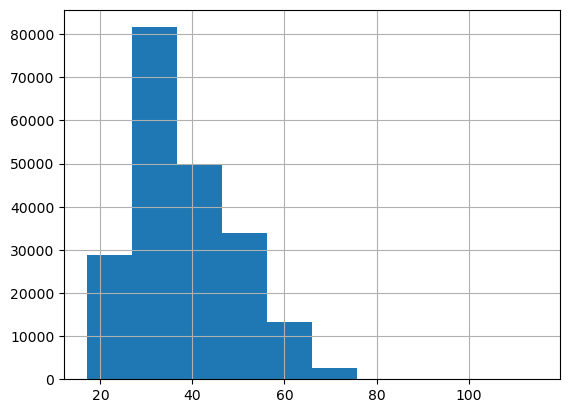

In [194]:
df['age'].hist()

### Split your data into train and test sets

Look at the size of your data. What is a good proportion for your split? 

Justify your answer.


In [195]:
# Answer here:
# It's okay to do 80/20

Use the `tripduration` column as your `y` variable.

For your `X` variables, use `age`, `usertype`, `gender`, and the dummy variables you created from `start station id`.

**NOTE:** When doing your train/test split, please use random seed 123.

In [196]:
# usertype has 2 values Subscriber and Customer
# df['usertype'].value_counts()
# usertype
# Subscriber    218019
# Customer        6717
# We will map Subscriber to 0 and Customer to 1

df['usertype'] = df['usertype'].map({'Subscriber': 0, 'Customer': 1})

In [197]:
df['usertype'].value_counts()

usertype
0    205548
1      4615
Name: count, dtype: int64

In [198]:
# Set features
features = ['age', 'usertype', 'gender'] + [col for col in df.columns if col.startswith('start station id_')]

# Train test split
X = df[features]
y = df['tripduration']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 123)

### Fit a linear regression model in `sklearn` predicting `tripduration`

In [199]:
linreg = LinearRegression()     # instantiate

linreg.fit(X_train, y_train)    # fit

LinearRegression()

### Evaluate your model

Look at some evaluation metrics for **both** the training and test data. 
- How did your model do? Is it overfit, underfit, or neither?
- Does this model outperform the baseline? (e.g. setting $\hat{y}$ to be the mean of our training `y` values.)

In [200]:
# Use dummy regressor to make a baseline
dummyreg = DummyRegressor()
dummyreg.fit(X_train, y_train)

print(f'score for the training set: {dummyreg.score(X_train, y_train)}')
print(f'score for the testing set: {dummyreg.score(X_test, y_test)}')

score for the training set: 0.0
score for the testing set: -7.938565582676915e-09


In [201]:
# Linear regression model

print(f'score for the training set: {linreg.score(X_train, y_train)}')
print(f'score for the testing set: {linreg.score(X_test, y_test)}')

score for the training set: 0.07135939562387461
score for the testing set: 0.06838001577569441


In [202]:
# Both baseline and our model are underfitting
# since score of training set is nearly 0.0 means the models did not capture any pattern
# And both models are so worse to conclude anything

### Analyze your model's residuals

**Analyze and interpret your model's errors.** 

Consider a histogram of residuals, a scatterplot of residuals vs. predicted, a scatterplot of actuals vs. predicted, etc. 

What sorts of mistakes is the model making? Do you notice any patterns?

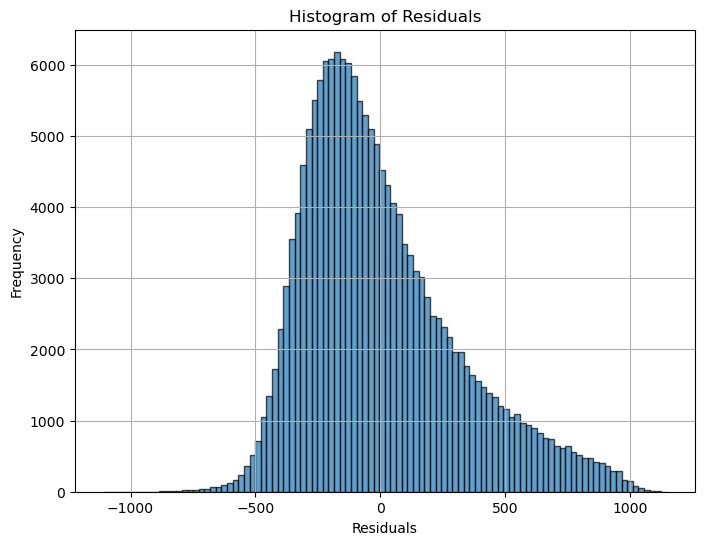

In [203]:
residuals = y_train - linreg.predict(X_train)

plt.figure(figsize=(8,6))
plt.hist(residuals, bins = 100, edgecolor = 'black', alpha = 0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

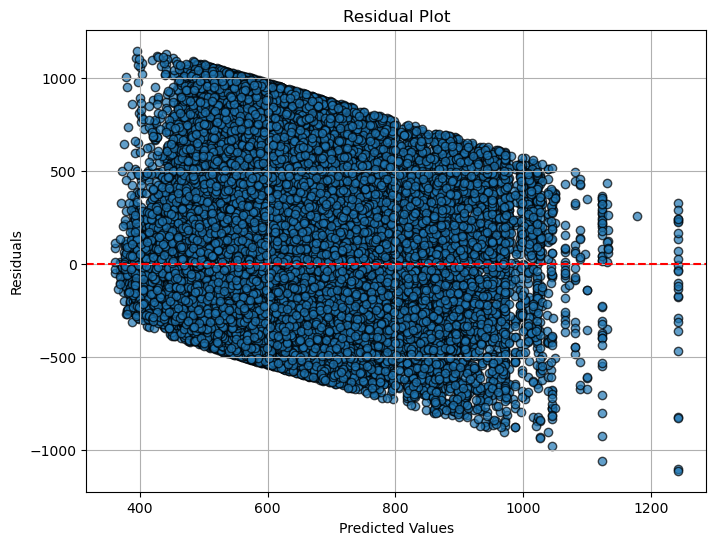

In [204]:
plt.figure(figsize = (8,6))
plt.scatter(linreg.predict(X_train), residuals, alpha = 0.7, edgecolors = 'black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [205]:
# The plot show that most data points are underestimated (positive skew)
# The model fails to predict large value

### Try Log Transform target

In [206]:
X = df[features]
y = np.log(df['tripduration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 123)

In [207]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [208]:
# Use dummy regressor to make a baseline
dummyreg = DummyRegressor()
dummyreg.fit(X_train, y_train)

print(f'score for the training set: {dummyreg.score(X_train, y_train)}')
print(f'score for the testing set: {dummyreg.score(X_test, y_test)}')

score for the training set: 0.0
score for the testing set: -1.364058088704212e-08


In [209]:
# Linear regression model

print(f'score for the training set: {linreg.score(X_train, y_train)}')
print(f'score for the testing set: {linreg.score(X_test, y_test)}')

score for the training set: 0.06346223380774829
score for the testing set: 0.061031482674567816
